# Primordial Earth
There are a wide variety of problems in the conext of the Solar System requiring accurate integration of N-bodies undergoing close encounters and/or collisions. Standard integrators such as IAS15 and WHFast might be insufficient for these types of problems.

In this example we investigate the primordial Earth embedded in a disk of planetesimals, integrating it for a short period of time using the MERCURIUS integrator. MERCURIUS is a hybrid integration scheme which combines the WHFAST and IAS15 algorithms in a similar way to the hybrid integrastor in the MERCURY package.

In [29]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

First let's choose the basic properties required for the MERCURIUS integrator. In particular, we are:  
* setting planetesimals to *semi-active* mode, which means they can influence active bodies but not other semi-active bodies.
* merge any planetesimals that collide with a planets, conserving momentum and mass.
* remove particles from the similation which leave our pre-defined box.
* track the energy lost due to ejections or collisions.  

In [30]:
sim = rebound.Simulation()

#integrator options
sim.integrator = "trace"
sim.ri_trace.S_peri = "none"
sim.dt = 0.025*2.*np.pi # we're working in units where 1 year = 2*pi
sim.testparticle_type = 1
#sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration 

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.track_energy_offset = 1

Now that the setup is complete, it's time to add some particles! When using the MERCURIUS integrator it is important to add active bodies first and semi-active bodies later. The `N_active` variable separates massive bodies from semi-active/test bodies. Here, we add two active particles, the Sun and the Earth. Thus, `N_active` will be 2.

In [31]:
sim.add(m=1.)
sim.add(m=3e-6,r=5e-5,a=1,e=0.05,f=np.pi)
sim.N_active = sim.N   # sim.N= 2

Now, let's create our planetesimal disk. First we define three different distribution functions - powerlaw, uniform and rayleigh.

In [32]:
def rand_powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

Next, let's set up the basic properties of our planetesimal disk. For this simple example we are assuming that all planetesimals have the same mass and radius.

In [33]:
N_pl = 1000                          # Number of planetesimals
Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
m_pl = Mtot_disk / float(N_pl)       # Mass of each planetesimal
r_pl = 2e-5                          # Radius of each planetesimal

Now let's add our planetesimals to the simulation!

In [34]:
np.random.seed(42) # by setting a seed we will reproduce the same simulation every time
while sim.N < (N_pl + sim.N_active):
    a = rand_powerlaw(0, 0.99, 1.01)
    e = rand_rayleigh(0.01)
    inc = rand_rayleigh(0.005)
    f = rand_uniform(-np.pi,np.pi) 
    p = rebound.Particle(simulation=sim,primary=sim.particles[0],m=m_pl, r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
    # Only add planetesimal if it's far away from the planet
    d = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
    if d>0.01: 
        sim.add(p)

We move to the COM frame to avoid having the simulation drive away from the origin. In addition, it is always good practice to monitor the change in energy over the course of a simulation, which requires us to calculate it before and after the simulation.

In [35]:
sim.move_to_com()
E0 = sim.energy()

Let's quickly plot the location of the particles with matplotlib:

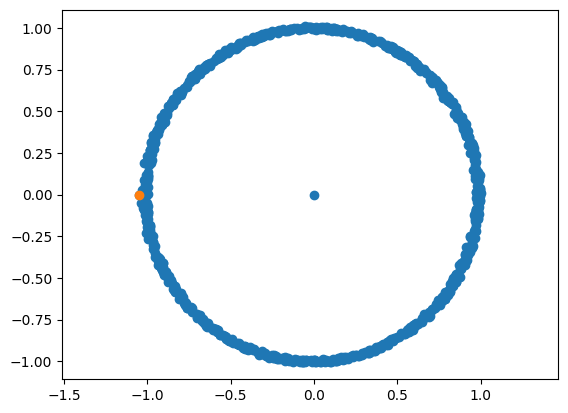

In [36]:
coords = np.zeros((2,sim.N))
for i in range(sim.N):
    coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
fig, ax = plt.subplots()
ax.axis('equal')
ax.scatter(coords[0],coords[1])
ax.scatter(sim.particles[1].x,sim.particles[1].y); # Planet

Finally, let us simulate our system for 100 years, and check that our final relative energy error is small. 

In [ ]:
times = np.linspace(0.,1.,1000)
encounter_N = np.zeros(len(times))
totalN = np.zeros(len(times))
errors = np.zeros(len(times))
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    totalN[i] = sim.N
    encounter_N[i] = sim.ri_trace._encounter_N
    errors[i] = abs((sim.energy() - E0)/E0)

The default values in this notebook yields an error of $\approx 10^{-8}$. The following plot shows the relative energy error, the number of particles within 3 Hill radii of the planet and the number of ejected/merged particles as a function of time. 

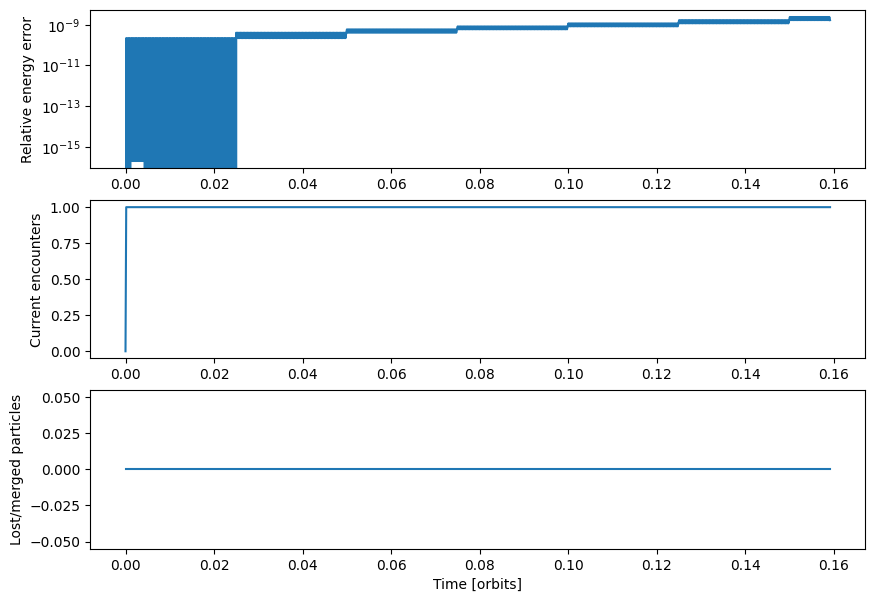

In [28]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(311)
plt.yscale("log")
plt.plot(times/(2.*np.pi), errors);
ax.set_ylabel("Relative energy error")
ax = plt.subplot(312)
ax.set_ylabel("Current encounters")
plt.plot(times/(2.*np.pi), encounter_N);
ax = plt.subplot(313)
ax.set_ylabel("Lost/merged particles")
ax.set_xlabel("Time [orbits]")
plt.plot(times/(2.*np.pi), -(totalN-N_pl-2));

Let us also plot the final positions of all particles. We can see that the planet stirred up the planetesimal disk.

In [ ]:
coords = np.zeros((2,sim.N))
for i in range(sim.N):
    coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
fig, ax = plt.subplots()
ax.axis('equal')
ax.scatter(coords[0],coords[1])
ax.scatter(sim.particles[1].x,sim.particles[1].y); # Planet